Let's start with our first Machine Learning Model: [sklearn.linear_model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

This model is a Gradient Descent one, which implies that I should use a scaler to normalize my dataset before fitting the model.

I've choosen to tune two of its parameters:

- The regularization strenght alpha, a float number

- The solver, to be choosen from a list provided by the Ridge model

Let's start by loading [my_utils](my_utils.ipynb) and other usefull libraries.

In [1]:
# Load my_utils.ipynb in Notebook
from ipynb.fs.full.my_utils import *

Opening connection to database
Add pythagore() function to SQLite engine
Fraction of the dataset used to train models: 10.00%
my_utils library loaded :-)


In [2]:
# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# PCA
from sklearn.decomposition import PCA

# Grid Search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Ridge Model
from sklearn.linear_model import Ridge

# Load train/valid data

Nothing special here, use the *loadXy()* function to load train/valid X and y datasets

In [3]:
# Load X and y
X_tr, y_tr, X_va, y_va=load_Xy(frac=FRAC_VALUE_FOR_ML)


# Pipeline and Grid Search

As explained in the previous [notebook](30.Machine%20Learning%20Models.ipynb), I will train my model using a Grid Search approach in combination with the Pipeline object.

Pipeline will include the following step:

- scaler, to scale the dataset if required by the model

- pca, to apply feature dimension reduction using PCA()

- model, the model to train

I'll do first a randomized search using as much parameters values as possible and, based on the result obtained, run a GridSearchCV with the best parameter intervals found with the randomized process.


## Define pipeline and grid parameters

Scaler and PCA will be configured in the Pipeline and manage as grid parameters:

### Scaler

- StandardScaler()

- MinMaxScaler()

- RobustScaler()

> Note: Scaler selection is inspired from that article: [All about Feature Scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

### PCA

- PCA(0.8)

- PCA(0.9)

- PCA(0.95)

For both PCA and Scaler, the pipeline will be configured to let the search process disable them (setting *None* as grid parameter), even if it's recommended to scale data when using *Gradient Descent* model types.

In [4]:
# Define list of scaler used in grid search
scalers=[StandardScaler(), MinMaxScaler(), RobustScaler(), None]

# Define list of PCA reduction used in grid search
pcas=[PCA(0.8), PCA(0.9), PCA(0.95), None]

In [5]:
# Initialize Ridge ML model
model = Ridge()

# Define pipeline with scaler, pca and model choosen
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("model", model),
])

# Define base grid search parameters
param_grid = {
    "scaler": scalers,
    "pca": pcas
}



## RandomizedSearchCV with large parameters scope

I will start with a *RandomizedSearchCV* on a very large scope of parameters, setting the iterations number to 100. My objective is to find out which hyperparameters and their interval works better to refine search later on using *GridSearchCV*.

> Note: Instead of using the default scoring function of the *GridSearchCV* class, I will use the one I've defined in [my_utils](my_utils.ipynb) library based on *Mean Absolute Percentage Error*.


In [6]:
# Set specific model parameters to param_grid
param_grid["model__alpha"]=np.logspace(-4, 15, 200)
param_grid["model__solver"]=['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']

# Number of random search iterations (the more the slower ;-) )
ITERATIONS=100

# Initialize RandomizedSearchCV object. Note that return_train_score=True
random_search = RandomizedSearchCV(pipe, param_grid, scoring=custom_scorer, random_state=RANDOM_STATE,
                                   n_iter=ITERATIONS, n_jobs=-1, cv=5, verbose=1, return_train_score=True)

# Do the random hyperparameter tuning search
random_search.fit(X_tr, y_tr)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'scaler': [StandardScaler(copy=True, with_mean=True, with_std=True), MinMaxScaler(copy=True, feature_range=(0, 1)), RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), None], 'pca': [PCA(copy=True, iterated_power='auto', n_compone....02643e+14, 1.00000e+15]), 'model__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
          pre_dispatch='2*n_jobs', random_state=47, refit=True,
   

### Results

Ok, randomized search will now help me to determine wich parameters I should use for best results.

The following code will display as a *pd.DataFrame* the result, sorted by *mean_test_score*, the score obtained with the test set (test set has been made by the *RandomSearchCV* class using a *KFold* approach).

In [7]:
# Build a dataframe from search.cv_results_
random_df=pd.DataFrame(random_search.cv_results_)

# Restrict to interesting columns
cols = [f'param_{key}' for key in param_grid.keys()]
cols+=['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']
random_df=random_df[cols]

# Print result
print("Best parameters found:", random_search.best_params_)
print("10 best results:")
random_df.sort_values('mean_test_score', ascending=False).head(10)



Best parameters found: {'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'pca': None, 'model__solver': 'saga', 'model__alpha': 0.0003739937302478798}
10 best results:


,param_scaler,param_pca,param_model__alpha,param_model__solver,mean_test_score,std_test_score,mean_train_score,std_train_score
51,"StandardScaler(copy=True, with_mean=True, with...",None,0.000373994,saga,87.802608,0.049827,87.807794,0.011967
65,None,None,0.0471375,cholesky,87.802574,0.049867,87.807779,0.011961
21,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,5.94113,lsqr,87.802567,0.048638,87.807863,0.011794
86,"MinMaxScaler(copy=True, feature_range=(0, 1))",None,0.000465953,sparse_cg,87.802476,0.050082,87.807621,0.011915
44,"StandardScaler(copy=True, with_mean=True, with...",None,5.94113,lsqr,87.801730,0.049668,87.806981,0.011957
7,"MinMaxScaler(copy=True, feature_range=(0, 1))",None,0.0471375,lsqr,87.795993,0.051412,87.801157,0.013136
40,"MinMaxScaler(copy=True, feature_range=(0, 1))",None,17.8343,lsqr,87.794566,0.053687,87.799967,0.011835
22,None,None,1.58857,saga,87.792082,0.056615,87.796927,0.012579
96,"StandardScaler(copy=True, with_mean=True, with...",None,5415.87,saga,87.786525,0.047088,87.791230,0.011854
89,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,2800.5,sag,87.744943,0.046490,87.749055,0.011978


### What can I do according to the above results ?

Well, decide which parameters I should keep and wich value I should give to them for the next Grid Search (without randomized approach)

- PCA

Top most results have been obtained without any PCA reduction, I will remove this feature reduction from the next grid search.

- Scaler

Regarding the scaler, *RobustScaler()*, *MinMaxScaler()* and *StandardScaler()* seems to perform equally, they are in the top most performer results.

There's one noticeable thing in this grid search result. One of the best performer is obtained without any scaler, certainly because the work done previously to normalize the dataset helps models in their training process. But looking at the *alpha* value used to perform without scaler, $4.10^{-2}$, lead me to ignore that result and prefer another result.

Same remark with *StandardScaler()* and *MinMaxScaler()*, their best results implies very low *alpha* values.

For that reason, I would prefer to choose the *RobustScaler()* which has it's best performance combination using an alpha value of 5.95

- Alpha

According to the choices made on the scaler, optimal value would be around *alpha=6*. I'll set the *alpha* search parameter to a range from $10^{-1}$ to $10^3$ to obtain a nice curve.

- What about solver ?

Difficult to say which solver performs best. Let's use the *lsqr*, the one that performs best with my scaler *RoubustScaler()* choice.


## GridSearchCV on more precise parameter intervals

Build and run a *GridSearchCV* with reduced parameter scope, fixing scaler to *RobustScaler()*, PCA to *None* and solver to *lsqr*

In [8]:
# Set specific model parameters to param_grid
param_grid["model__alpha"]=np.logspace(-1, 4, 100)
param_grid["model__solver"]=['lsqr']
param_grid['scaler']=[RobustScaler()]
param_grid['pca']=[None]


# Initialize GridSearchCV object. Note that return_train_score=True
grid_search = GridSearchCV(pipe, param_grid, scoring=custom_scorer, n_jobs=-1, cv=5, verbose=1, return_train_score=True)

# Do the grid search
grid_search.fit(X_tr, y_tr)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'scaler': [RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'pca': [None], 'model__alpha': array([1.00000e-01, 1.12332e-01, ..., 8.90215e+03, 1.00000e+04]), 'model__solver': ['lsqr']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mape), verbose=1)

### Results

In [9]:
# Build a dataframe from search.cv_results_
grid_df=pd.DataFrame(grid_search.cv_results_)

# Restrict to interesting columns
cols = [f'param_{key}' for key in param_grid.keys()]
cols+=['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']

# Restrict to interesting columns
grid_df=grid_df[cols]

print("Best parameters found:", grid_search.best_params_)
print("10 best results:")
grid_df.sort_values('mean_test_score', ascending=False).head(10)


Best parameters found: {'model__alpha': 23.644894126454073, 'model__solver': 'lsqr', 'pca': None, 'scaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)}
10 best results:


,param_scaler,param_pca,param_model__alpha,param_model__solver,mean_test_score,std_test_score,mean_train_score,std_train_score
47,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,23.6449,lsqr,87.802579,0.048563,87.807859,0.011804
48,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,26.5609,lsqr,87.802579,0.048552,87.807856,0.011805
46,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,21.049,lsqr,87.802579,0.048574,87.807861,0.011802
49,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,29.8365,lsqr,87.802578,0.048538,87.807853,0.011807
45,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,18.7382,lsqr,87.802578,0.048584,87.807862,0.011801
44,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,16.681,lsqr,87.802577,0.048592,87.807863,0.011799
50,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,33.516,lsqr,87.802576,0.048524,87.807847,0.011809
43,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,14.8497,lsqr,87.802576,0.048599,87.807864,0.011798
42,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,13.2194,lsqr,87.802575,0.048606,87.807864,0.011797
41,"RobustScaler(copy=True, quantile_range=(25.0, ...",None,11.7681,lsqr,87.802574,0.048613,87.807864,0.011797


### Graphical representation of results

Here is a nice curve showing the role of hyperparameters tuning :-)

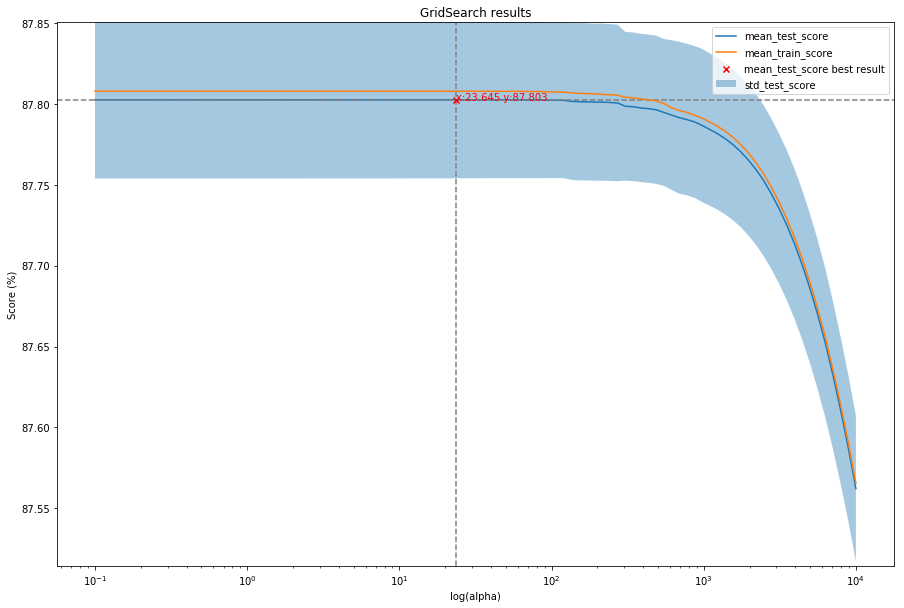

In [10]:
# Parameter name to plot
MODEL_PARAM='alpha'

# Plot train and validation curve
results_df=grid_df.sort_values(f'param_model__{MODEL_PARAM}')

plot_grid_search_results(results_df, x_param=f'param_model__{MODEL_PARAM}', semilogx=True, xlabel=MODEL_PARAM)

# Prediction

Now that I've found the best parameters and get the best estimator via *GridSearchCV()*, let's calculate prediction score of this model.

In [11]:
# Get best estimator from grid search and predict using X_va
y_pred=grid_search.predict(X_va)

# Get the MAE and MAPE from y_pred
print("Ridge model mean absolute error         : {:.3f} km/h".format(mae(y_pred, y_va)))
print("Ridge model mean absolute percent error : {:.2f} %".format(mape(y_pred, y_va)))


Ridge model mean absolute error         : 1.357 km/h
Ridge model mean absolute percent error : 87.55 %


## Remark

I suspect since the beginning of my work on data analysis that my dataset might have a bias.

Looking at the y vector result, I can see that most of the travel are centered around 11 km/h.


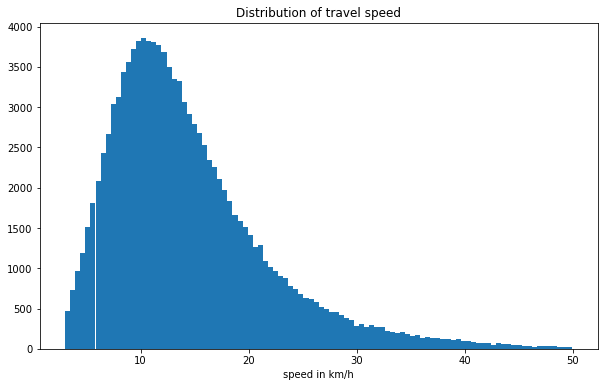

In [12]:
plt.figure(figsize=(10,6))
plt.hist(10**y_tr, bins=100)
plt.title('Distribution of travel speed')
plt.xlabel('speed in km/h')
plt.show()

Consequence of this dataset characteristics, the bias I suspect is that if you systematically predict a value around the average of travel speed, the same way *DummyRegressor* work, your prediction score would be not so bad.

This can be confirmed by the score obtained by the *DummyRegressor()* on this dataset which reach 84%.


### Can we observe this bias ?

Let's graph the prediction score of the *Ridge* model I've trained, splitted by groups of 5 km/h real value (the one taken from *y_va* vector): 5 to 10 km/h, 10 to 15 km/h, 15 to 20 km/h and so on...

What I can observe is that score value is the highest in the 10 to 15 km/h interval, the one where most of the travels are, and score decrease when we get far from this optimal interval.

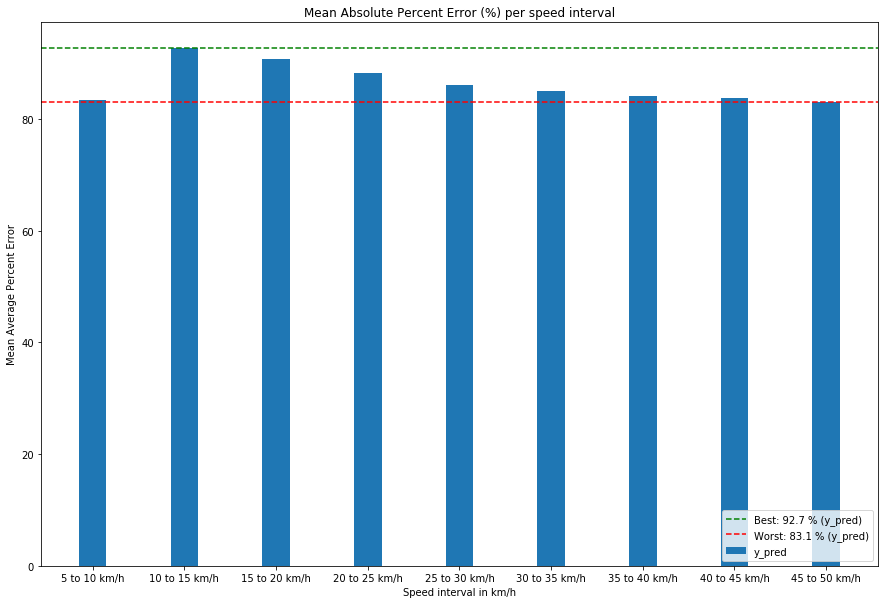

In [13]:
# Draw graph using function from my_utils library
df=pd.DataFrame({'y': y_va, 'y_pred': y_pred})
draw_mape_per_speed_interval(df,columns=['y_pred'])

That's it, I was not so wrong with the travel speed bias.

The previous graphs demonstrate that when speed is predicted between 10 to 15 km/h, the *Mean Average Percent Error* score is the best (more than 90%), and as long we get far from this value, the model prediction is going worst (a bit more than 80%)

# Save model

> Note: The model saved here is the *GridSearchCV* object as when I will reload it, I want to be sure that any pre-processing step like scaling will be applied when computing predictions.

In [14]:
save_model(grid_search, 'ridge')

Saving model ridge to ./data/model-ridge.sav using 'pickle' library


# What about PCA ? 

We'seen in the [Principal Component Analysis](22.Principal%20Component%20Analysis.ipynb) notebook that most of the variance (90%) could be explained using nearly half of the features.

Let's run the same grid search as above twice, first run adding a *PCA(0.9)* step to the *Pipeline* and second run adding a *PCA(0.8)* step, and compare the prediction of the best estimators for those two runs with the result obtain without *PCA()*.


## GridSearch with PCA(0.9)

Set *PCA(0.9)* to the *pcas* grid search parameter and rerun the search process.

In [15]:
# Set pca grid param to PCA(0.9)
param_grid['pca']=[PCA(0.9)]

# Initialize GridSearchCV object. Note that return_train_score=True
pca_90_grid_search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, verbose=1, return_train_score=True)

# Do the grid search
pca_90_grid_search.fit(X_tr, y_tr)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'scaler': [RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'pca': [PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)], 'model__alpha': array([1.00000e-01, 1.12332e-01, ..., 8.90215e+03, 1.00000e+04]), 'model__solver': ['lsqr']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [16]:
# Get best estimator from grid search and predict using X_va
pca_90_y_pred=pca_90_grid_search.predict(X_va)

# Get the MAE and MAPE from y_pred
print("Ridge model with PCA(0.9) mean absolute error         : {:.3f} km/h".format(mae(pca_90_y_pred, y_va)))
print("Ridge model with PCA(0.9) mean absolute percent error : {:.2f} %".format(mape(pca_90_y_pred, y_va)))

Ridge model with PCA(0.9) mean absolute error         : 1.373 km/h
Ridge model with PCA(0.9) mean absolute percent error : 87.05 %


## GridSearch with PCA(0.8)

Let's redo the same grid search using *PCA(0.8)*.

In [17]:
# Set pca grid param to PCA(0.8)
param_grid['pca']=[PCA(0.8)]

# Initialize GridSearchCV object. Note that return_train_score=True
pca_80_grid_search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, verbose=1, return_train_score=True)

# Do the grid search
pca_80_grid_search.fit(X_tr, y_tr)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'scaler': [RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'pca': [PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)], 'model__alpha': array([1.00000e-01, 1.12332e-01, ..., 8.90215e+03, 1.00000e+04]), 'model__solver': ['lsqr']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [18]:
# Get best estimator from grid search and predict using X_va
pca_80_y_pred=pca_80_grid_search.predict(X_va)

# Get the MAE and MAPE from y_pred
print("Ridge model with PCA(0.8) mean absolute error         : {:.3f} km/h".format(mae(pca_80_y_pred, y_va)))
print("Ridge model with PCA(0.8) mean absolute percent error : {:.2f} %".format(mape(pca_80_y_pred, y_va)))

Ridge model with PCA(0.8) mean absolute error         : 1.386 km/h
Ridge model with PCA(0.8) mean absolute percent error : 86.67 %


## Compare results

The bar graph below represents the model performance obtained with different *PCA()* configuration.

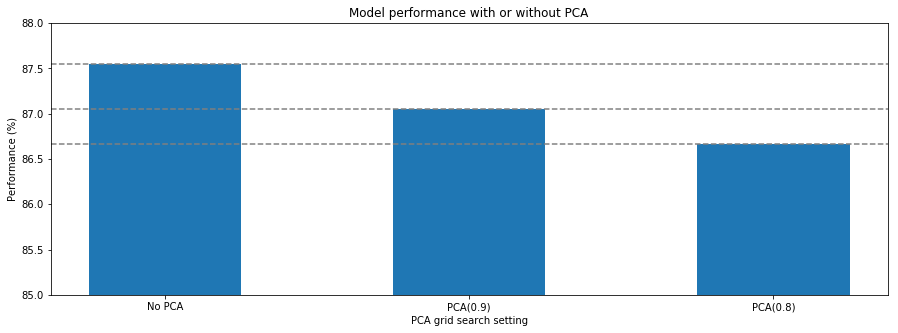

In [19]:
df=pd.DataFrame({
    'pca': [0,1,2],
    'prediction': [mape(y_pred, y_va), mape(pca_90_y_pred, y_va), mape(pca_80_y_pred, y_va)]
})
plt.figure(figsize=(15,5))
plt.bar(df['pca'], df['prediction'], width=0.5)

for i in df['prediction']:
    plt.axhline(y=i, color='grey', linestyle='--')

plt.xticks(ticks=[0,1,2], labels=['No PCA', 'PCA(0.9)', 'PCA(0.8)'])
plt.xlabel("PCA grid search setting")

plt.ylim(85, 88)
plt.ylabel("Performance (%)")

plt.title("Model performance with or without PCA")
plt.show()


Compared to the result we've obtained without PCA, conclusion is that using PCA reduction does not perform so bad, but a bit lower than without PCA.


## Save model with PCA(0.9) and PCA(0.8)

In [20]:
save_model(pca_90_grid_search, 'ridge-pca90')

Saving model ridge-pca90 to ./data/model-ridge-pca90.sav using 'pickle' library


In [21]:
save_model(pca_80_grid_search, 'ridge-pca80')

Saving model ridge-pca80 to ./data/model-ridge-pca80.sav using 'pickle' library


## Time to go to the next model

A distance based one, the [KNeighborsRegressor](32.Distance%20Based%20-%20KNeighborsRegressor.ipynb)